# Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [4]:
"""Load DataFrame"""
#df=pd.read_csv('vehicles.csv')
train=pd.read_csv("C:/Users/dell/Desktop/UsedCars/train.csv", index_col=0)

train.head(1)


,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date,price
121610,7309831550,2007.0,infiniti,m45,excellent,NaN,gas,214740.0,clean,automatic,rwd,NaN,sedan,black,ga,34.139588,-83.971135,2021-04-20T11:46:13-0400,7995


In [6]:
test=pd.read_csv("C:/Users/dell/Desktop/UsedCars/test.csv", index_col=0)

test.head(1)

,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date
316575,7313399730,2018.0,honda,civic,NaN,4 cylinders,gas,28898.0,clean,automatic,fwd,NaN,sedan,NaN,or,44.97143,-123.018548,2021-04-27T10:09:18-0700


# 1) Dealing with missing values

In [7]:
train.isnull().sum() #return series of columns with respective of number of null values

id                   0
year                 0
manufacturer     11342
model                0
condition       116104
cylinders       119300
fuel              1453
odometer             0
title_status      5066
transmission         0
drive            88087
size            207684
type             62596
paint_color      87113
state                0
lat               4403
long              4403
posting_date         0
price                0
dtype: int64

<Axes: >

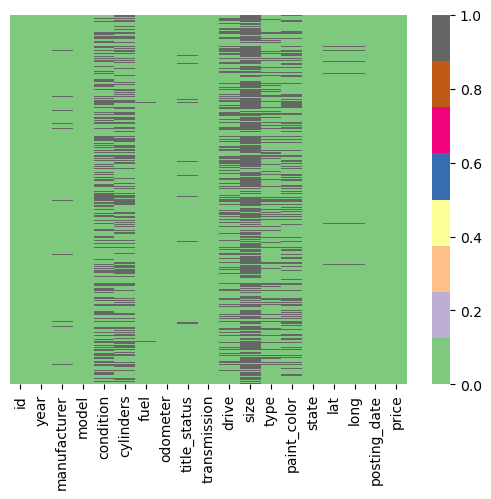

In [8]:
#heatmap to identify nulll values using graph
sns.heatmap(train.isnull(),yticklabels=False,cbar=True,cmap='Accent')

Text(0, 0.5, '% null')

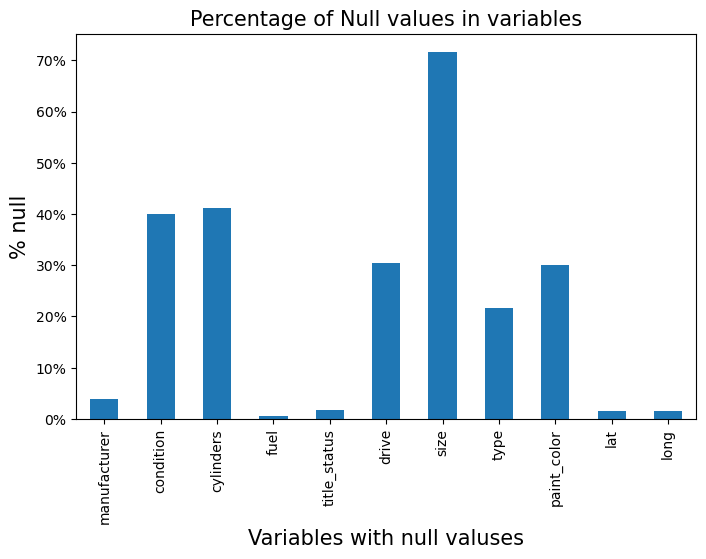

In [9]:
nulls_df = pd.DataFrame(train.isnull().sum()[train.isnull().sum() != 0])
nulls_df['%null'] =  (nulls_df[0] / train.shape[0]) * 100
ax = nulls_df['%null'].plot(kind='bar', figsize=(8, 5))

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Percentage of Null values in variables', fontsize=15)
plt.xlabel('Variables with null valuses', fontsize=15)
plt.ylabel('% null', fontsize=15)

**We are going to drop:**
    
1- year and posting_date after calculate the age.

2- size because it has more that 70% of null values.

3- lat and long because thay do not give any information. 

In [10]:
#define numeric variable and categorical variable to work separatly on them
num_col=['age','odometer']
cat_cols=['manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','type','paint_color','state']

In [11]:
train.year=train.year.astype(int)
test.year=test.year.astype(int)

train['post_date'] = train['posting_date'].str[:4]
test['post_date'] = test['posting_date'].str[:4]

train.post_date=train.post_date.astype(int)
test.post_date=test.post_date.astype(int)

train_age=train.post_date-train.year
train.insert(1, 'age', train_age)

test_age=test.post_date-test.year
test.insert(1, 'age', test_age)


In [12]:
train.head(1)

,id,age,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,...,drive,size,type,paint_color,state,lat,long,posting_date,price,post_date
121610,7309831550,14,2007,infiniti,m45,excellent,NaN,gas,214740.0,clean,...,rwd,NaN,sedan,black,ga,34.139588,-83.971135,2021-04-20T11:46:13-0400,7995,2021


In [13]:
train.drop(['year','size','lat','long','posting_date', 'post_date'], axis=1, inplace=True)
test.drop(['year','size','lat','long','posting_date', 'post_date'], axis=1, inplace=True)

# 2.1) Estimating better iterative imputer method

In [14]:
check_imputer=train.copy()


#object of LabelEncoder
encoder=preprocessing.LabelEncoder()

#function to label the categorical columns ignoring null values 
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#loop to label each column or categorical values into numberic
for i in tqdm(range(len(cat_cols))):
    encode(check_imputer[cat_cols[i]])

100%|██████████| 11/11 [00:01<00:00,  5.99it/s]


In [15]:
check_imputer.head()

,id,age,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,price
121610,7309831550,14,18,15798,0,NaN,2,214740.0,0,0,2,9,0,10,7995
395646,7317007429,13,6,10830,NaN,NaN,2,170276.0,0,0,NaN,0,0,47,14999
236366,7309202024,18,23,10786,NaN,NaN,2,176910.0,0,0,1,9,NaN,27,5995
66001,7306341714,4,4,2061,0,NaN,2,41000.0,0,0,0,0,NaN,4,0
320855,7307880118,13,38,18455,2,5,2,138900.0,0,0,0,0,9,38,7995


In [16]:
"""metrics which measure the distance between the model
and the data, like metrics. mean_squared_error ,
are available as neg_mean_squared_error
which return the negated value of the metric."""


'metrics which measure the distance between the model\nand the data, like metrics. mean_squared_error ,\nare available as neg_mean_squared_error\nwhich return the negated value of the metric.'

In [17]:
# Estimate the score on the entire dataset by filling missing values by mean and median

br_estimator = BayesianRidge() #base estimator
N_SPLITS = 6  #defining the cross-validation splitting strategy

score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=check_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(check_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Create a list of estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=42),
    ExtraTreesRegressor(n_estimators=10, random_state=42),
    KNeighborsRegressor(n_neighbors=3)
]

# Initialize the DataFrame to store the scores
score_iterative_imputer = pd.DataFrame()

# Assuming you have a DataFrame named "check_imputer" with missing values to be imputed
df_new = check_imputer.copy()

for esti in estimators:
    print("Estimating", esti.__class__.__name__)
    
    # Initialize the IterativeImputer with the appropriate estimator
    imputer = IterativeImputer(estimator=esti)

    # Impute missing values for each column separately
    for col in check_imputer.columns:
        impute_data = imputer.fit_transform(df_new[col].values.reshape(-1, 1))
        df_new[col] = impute_data
        
    X = df_new.iloc[:, :-1]
    y = np.ravel(df_new.iloc[:, -1:])
    
    # Perform cross-validation and store the results in the DataFrame
    score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti, X, y, scoring='neg_mean_squared_error', cv=6)


Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor


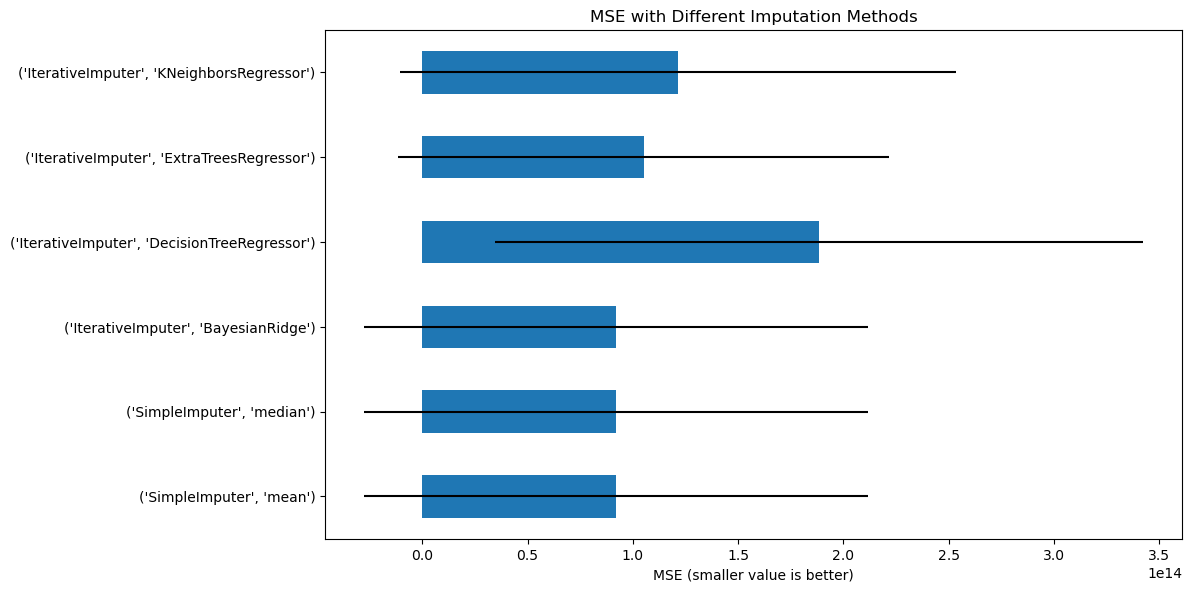

In [19]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.savefig('different-imputations-method',dpi=None)
plt.show()

## 2.4) Filling Categorical values

In [20]:
#Missing values before filling
train.isnull().sum()[cat_cols]

manufacturer     11342
model                0
condition       116104
cylinders       119300
fuel              1453
title_status      5066
transmission         0
drive            88087
type             62596
paint_color      87113
state                0
dtype: int64

In [21]:
data_cat=train[cat_cols]
encoder=preprocessing.LabelEncoder()

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(data_cat[columns])
    imputer = IterativeImputer(BayesianRidge())
    impute_data=imputer.fit_transform(data_cat[columns].values.reshape(-1, 1))
    impute_data=impute_data.astype('int64')
    impute_data = pd.DataFrame(impute_data)
    impute_data =encoder.inverse_transform(impute_data.values.reshape(-1, 1))
    data_cat[columns]=impute_data
train[cat_cols]=data_cat    

In [22]:
data_cat=test[cat_cols]
encoder=preprocessing.LabelEncoder()

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(data_cat[columns])
    imputer = IterativeImputer(BayesianRidge())
    impute_data=imputer.fit_transform(data_cat[columns].values.reshape(-1, 1))
    impute_data=impute_data.astype('int64')
    impute_data = pd.DataFrame(impute_data)
    impute_data =encoder.inverse_transform(impute_data.values.reshape(-1, 1))
    data_cat[columns]=impute_data
test[cat_cols]=data_cat 

In [23]:
#Missing values after filling
train.isnull().sum()[cat_cols]

manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

In [24]:
test.isnull().sum()[cat_cols]

manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

<Axes: >

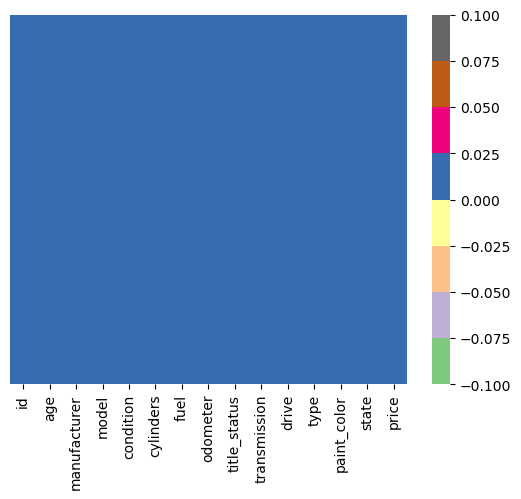

In [25]:
#Heat map tp check numm values visually
sns.heatmap(train.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [26]:
#No null value in the dataset 
test.isnull().sum()

id              0
age             0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

# 3) Outliers

In [27]:
from IPython.display import display,Latex
outliers_condi=Latex(r" $\textbf{W𝑒 𝑐𝑎𝑛 𝑠𝑎𝑦 $𝑥_1$ or $x_2$ 𝑖𝑠 𝑜𝑢𝑡𝑙𝑖𝑒𝑟𝑠 if }\\ x_1 < Q1 - 1.5*IQR \\ or\\ x_2 > Q3+1.5*IQR $")


In [28]:

display(outliers_condi)

<IPython.core.display.Latex object>

In [29]:
#it will return the range of the variables and the values outside this range will be outliers
def outliers(arr,col):
    x=sorted(arr[col].values.ravel())
    L_25=25/100*(len(x)+1) #L_p where p=25%
    i_p=int(str(L_25).split(".")[0])
    f_p=int(str(L_25).split(".")[1])
    q1=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    L_75=75/100*(len(x)+1) #L_p where p=75%
    i_p=int(str(L_75).split(".")[0])
    f_p=int(str(L_75).split(".")[1])
    q3=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    #q1,q3=(arr[col].quantile([0.25,0.75]))
    
    IQR=q3-q1
    x1=q1-1.5*IQR
    x2=q3+1.5*IQR
    return (x1,x2)

## 3.1) Price

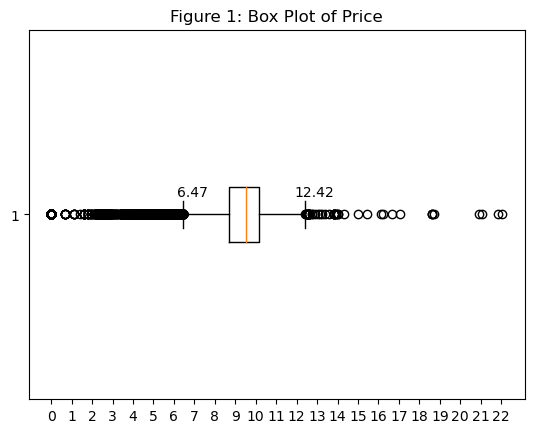

In [30]:
def min_max_price(df):
    r=[]
    q1,q3=(df['logprice'].quantile([0.25,0.75]))
    r.append(q1-1.5*(q3-q1))
    r.append(q3+1.5*(q3-q1))
    return (r)
train['logprice'] = np.log(train['price'])
x=train['logprice']
price_range=list(range(0,int(max(train['logprice']))+1))
red_square = dict(markerfacecolor='g', marker='s')
plt.boxplot(x, vert=False)
plt.xticks(price_range)
plt.text(min_max_price(train)[0]-0.3,1.05,str(round(min_max_price(train)[0],2)))
plt.text(min_max_price(train)[1]-0.5,1.05,str(round(min_max_price(train)[1],2)))
plt.title("Figure 1: Box Plot of Price")
plt.savefig('graph-boxplot-price.jpg')
plt.show()

## 3.2) Odometer

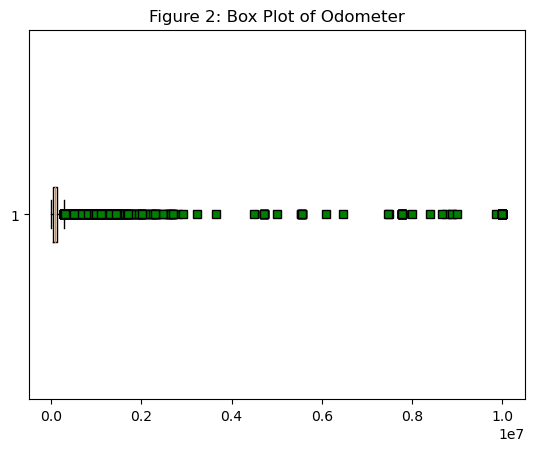

In [31]:
fig, ax1 = plt.subplots()
ax1.set_title('Figure 2: Box Plot of Odometer')
ax1.boxplot(train['odometer'], vert=False, flierprops=red_square)
plt.savefig('graph-boxplot-odometer.jpg')
plt.show()

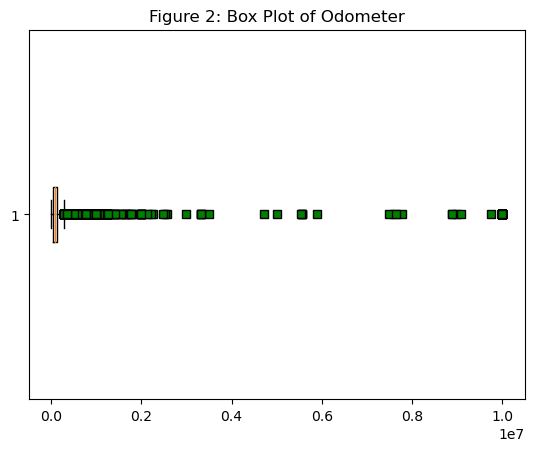

In [32]:
fig, ax1 = plt.subplots()
ax1.set_title('Figure 2: Box Plot of Odometer')
ax1.boxplot(test['odometer'], vert=False, flierprops=red_square)
plt.savefig('graph-boxplot-odometer.jpg')
plt.show()

## 3.3) Year

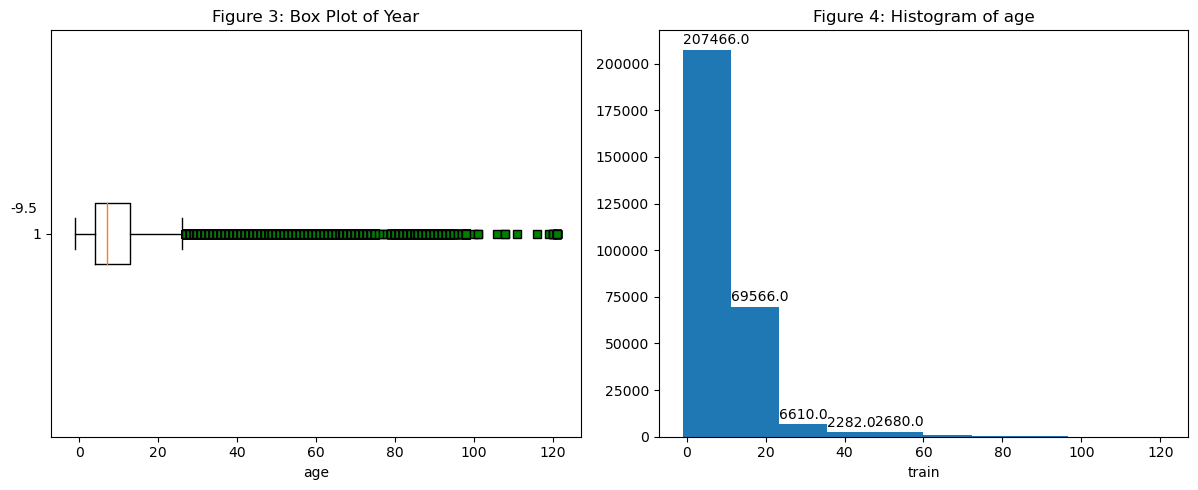

In [33]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

#ploting boxplot
o1,o2=outliers(train,'age')
ax1.boxplot(sorted(train['age']), vert=False, flierprops=red_square)
ax1.set_xlabel("age")
ax1.set_title("Figure 3: Box Plot of Year")
ax1.text(o1-8,1.05,str(round(o1,2)))

#ploting histogram
hist,bins=np.histogram(train['age'])
n, bins, patches = ax2.hist(x=train['age'], bins=bins)
ax2.set_xlabel("train")
ax2.set_title("Figure 4: Histogram of age")
for i in range(len(n)):
    if(n[i]>2000):
        ax2.text(bins[i],n[i]+3000,str(n[i]))

plt.tight_layout()
plt.savefig('graph-barplot-histogram-age.jpg',dpi=1200)
plt.show()

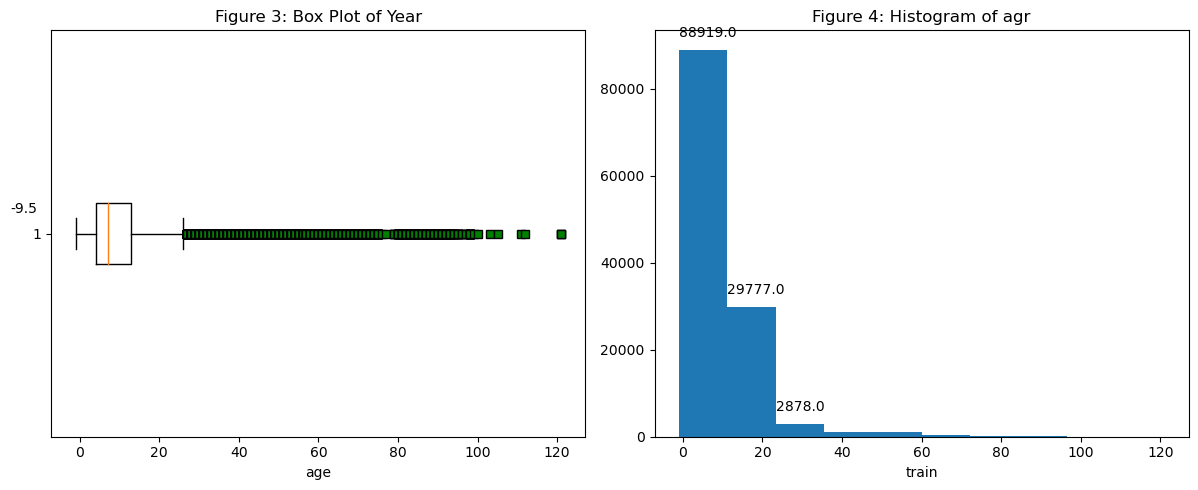

In [34]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

#ploting boxplot
o1,o2=outliers(test,'age')
ax1.boxplot(sorted(test['age']), vert=False, flierprops=red_square)
ax1.set_xlabel("age")
ax1.set_title("Figure 3: Box Plot of Year")
ax1.text(o1-8,1.05,str(round(o1,2)))

#ploting histogram
hist,bins=np.histogram(test['age'])
n, bins, patches = ax2.hist(x=test['age'], bins=bins)
ax2.set_xlabel("train")
ax2.set_title("Figure 4: Histogram of agr")
for i in range(len(n)):
    if(n[i]>2000):
        ax2.text(bins[i],n[i]+3000,str(n[i]))

plt.tight_layout()
plt.savefig('graph-barplot-histogram-age.jpg',dpi=1200)
plt.show()

In [35]:
#removing outliers 
df_new=train.copy()
out=np.array(['logprice','odometer','age'])
for col in out:
    o1,o2=outliers(df_new,col)
    df_new=df_new[(df_new[col]>=o1) & (df_new[col]<=o2)]
    print('IQR of',col,'=',o1,o2)
df_new=df_new[df_new['price']!=0]
df_new.drop('logprice',axis=1,inplace=True)

IQR of logprice = 6.467684037248342 12.415229596809898
IQR of odometer = -107637.5 282182.5
IQR of age = -9.5 26.5


<Axes: xlabel='age'>

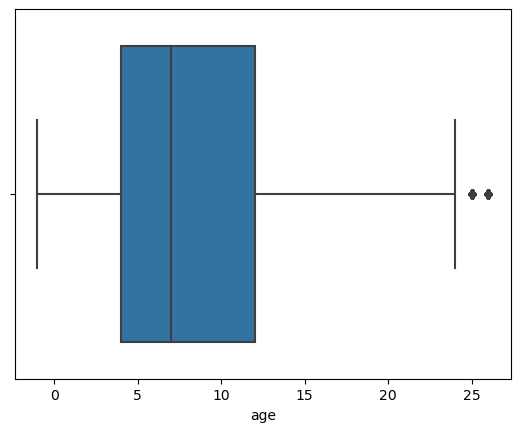

In [36]:
sns.boxplot(x=df_new.age)

In [37]:
df_new.head(1)

,id,age,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,price
121610,7309831550,14,infiniti,m45,excellent,5 cylinders,gas,214740.0,clean,automatic,rwd,sedan,black,ga,7995


In [39]:
print("Shape before process=",train.shape)
print("Shape After process=",df_new.shape)
diff=train.shape[0]-df_new.shape[0]
print("Total {} rows and {} cols removed".format(diff,train.shape[1]-df_new.shape[1]))
df_new.to_csv("C:/Users/dell/Desktop/UsedCars/new_train.csv",index=False)

Shape before process= (290129, 16)
Shape After process= (249474, 15)
Total 40655 rows and 1 cols removed


In [45]:
test.to_csv("C:/Users/dell/Desktop/UsedCars/new_test.csv",index=False)

In [50]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # Step 1: Load the test data from the CSV file
# test_data_path = "C:/Users/dell/Desktop/UsedCars/new_test.csv"
# test_data = pd.read_csv(test_data_path)

# # Assuming your target column (y) is named 'target_column_name', replace it with the actual name from your dataset
# # Also, make sure your features (X) are properly set up in the test_data

# # Assuming your target column (y) is the last column in the test_data, you can split the data like this:
# X_test = test_data.iloc[:, :-1]
# y_test = test_data.iloc[:, -1]

# # Step 2: Load the trained random forest model
# # Load your trained random forest model using pickle or any other method you used to save the model

# # Example using pickle (replace 'model_path' with the actual path to your saved model)
# import pickle
# with open('model_path', 'rb') as file:
#     rf_model = pickle.load(file)

# # Step 3: Use the model to make predictions on the test data
# y_pred = rf_model.predict(X_test)

# # Step 4: Calculate the accuracy score
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy Score:", accuracy)


In [52]:
# import pandas as pd

# data_path = "path/to/your/dataset.csv"  # Replace with the actual path to your dataset
# data = pd.read_csv(data_path)

# # Display the first few rows of the DataFrame to check the column names
# print(data.head())

# # If 'price' is not found in the columns, check for any discrepancies in the column names
# print(data.columns)



FileNotFoundError: [Errno 2] No such file or directory: 'path/to/your/dataset.csv'

In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load and preprocess the dataset
data_path = "C:/Users/dell/Desktop/UsedCars/new_test.csv"  # Replace with the actual path to your dataset
data = pd.read_csv(data_path)

# Preprocess the data, handle missing values, data cleaning, and feature engineering if needed
# Assuming 'price' is the target variable
X = data.drop(columns=['price'])  # Features (independent variables)
y = data['price']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # You can change the hyperparameters as needed
rf_model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Step 5: Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


KeyError: "['price'] not found in axis"